# Song Recommendation System

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score, silhouette_score

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

In [2]:
file_path_songs = "Data/df_combined.csv"
df_songs = pd.read_csv(file_path_songs)
file_path_songs_original = "Data/Music Info.csv"
df_songs_original = pd.read_csv(file_path_songs_original)
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)

## Data Inspection

##### Correlation matrix of selected features

/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


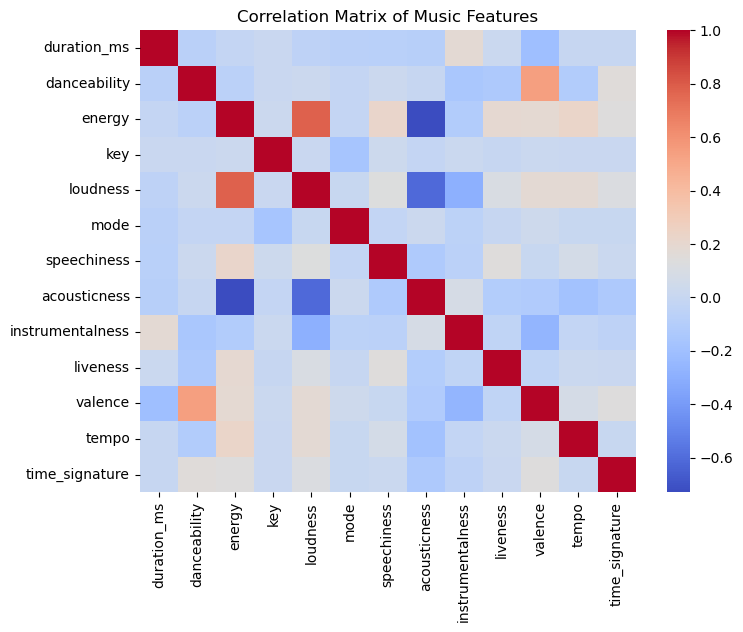

In [3]:
# Extract the relevant data from the DataFrame
selected_columns = ['duration_ms', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 
                    'tempo', 'time_signature']

music_data = df_songs[selected_columns]

# Calculate and plot the correlation matrix
correlation_matrix = music_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Music Features')
plt.show()

##### Visualisation of missing data, before and after

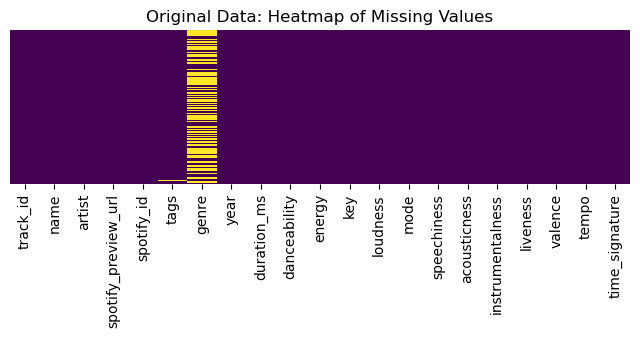

In [4]:
# Plot heatmap of missing values for entire dataframe
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_songs_original.isnull(),  # Check for missing values across the entire DataFrame
    cmap='viridis',  # Use a colormap
    cbar=False,  # Hide the color bar
    yticklabels=False,  # Remove y-axis tick labels for readability
)
plt.title('Original Data: Heatmap of Missing Values') 
plt.show()

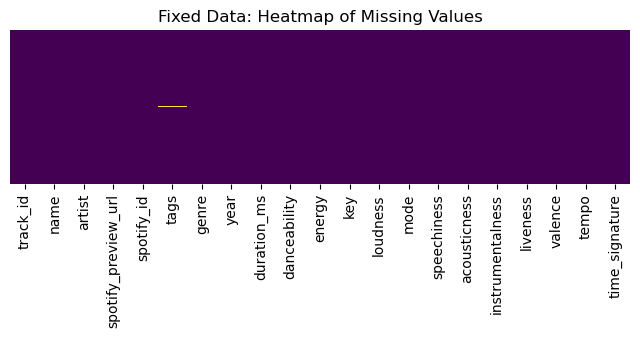

In [5]:
# Plot heatmap of missing values for the entire DataFrame after predicting genre with Neural Network
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_songs.isnull(),  # Check for missing values across the entire DataFrame
    cmap='viridis',  # Use a colormap
    cbar=False,  # Hide the color bar
    yticklabels=False,  # Remove y-axis tick labels for readability
)
plt.title('Fixed Data: Heatmap of Missing Values')  
plt.show()

I believe this explains why we could use the neural network to predict genre for those observations where the attribute is missing.

##### Plot top 15 most played songs

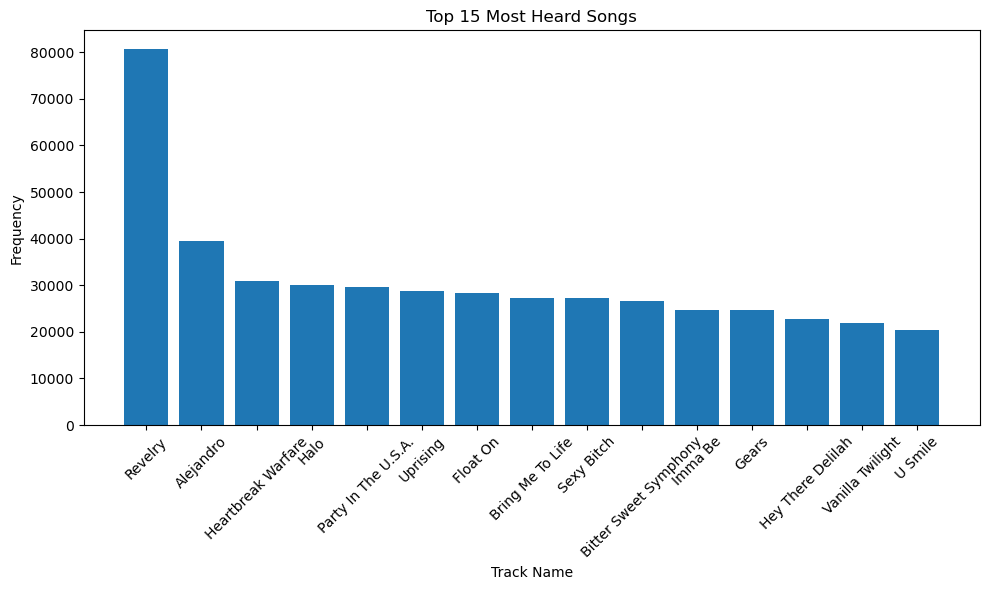

In [6]:
track_freq = df_users['track_id'].value_counts().reset_index()
track_freq.columns = ['track_id', 'frequency']

track_freq = track_freq.merge(df_songs, on='track_id')

top_15_tracks = track_freq.head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_15_tracks['name'], top_15_tracks['frequency'])
plt.xlabel('Track Name')
plt.ylabel('Frequency')
plt.title('Top 15 Most Heard Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clustering: Cluster the user base with K-means clustering

Cluser on both numeric and categorical features. Using One-hot encoding to handle the categorical feature 'genre'. Using Elbow method ans Silhouette score to find optimal k value. Using Davies-Bouldin Index to evaluate the clusters.

In [7]:
# One-hot encoding the genre column
genre_encoded = pd.get_dummies(df_songs['genre'], prefix='genre')

# Include all relevant numeric attributes
song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                 'tempo', 'year']  

# Combine genre and numeric attributes
numeric_features = df_songs[song_features]
song_data = pd.concat([genre_encoded, numeric_features], axis=1)

# Normalize the data
scaler = StandardScaler()
scaled_songs = scaler.fit_transform(song_data)

##### Elbow method for finding the optimal k-value

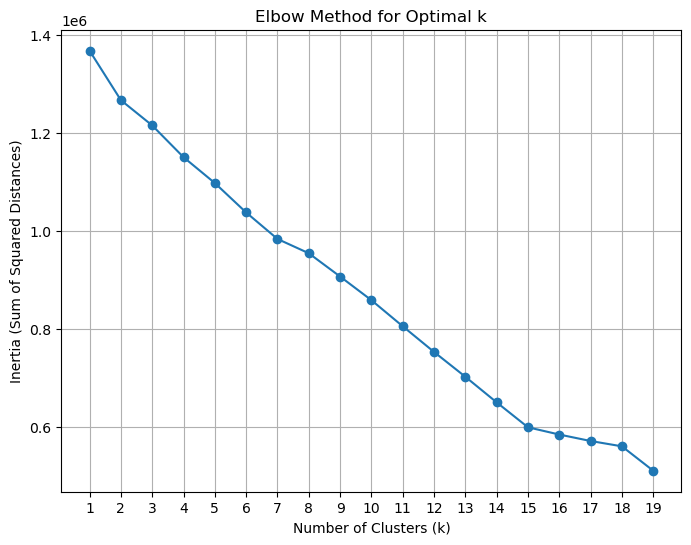

In [8]:
# Define the range of k values to test
k_values = range(1, 20)  
inertia = []  

# Perform K-Means clustering for each k and calculate inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_songs)  # scaled_songs is your normalized dataset
    inertia.append(kmeans.inertia_)

# Plot the inertia values against k
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values)  # Ensure all k values are labeled
plt.grid()
plt.show()

##### Calculate the Silhouette score to decide between 7 and 15 clusters

In [9]:
# For k = 15
kmeans_15 = KMeans(n_clusters=15, random_state=42).fit(scaled_songs)
silhouette_15 = silhouette_score(scaled_songs, kmeans_15.labels_)
print(f"Silhouette Score for k=15: {silhouette_15}")

# For k = 7
kmeans_7 = KMeans(n_clusters=7, random_state=42).fit(scaled_songs)
silhouette_7 = silhouette_score(scaled_songs, kmeans_7.labels_)
print(f"Silhouette Score for k=7: {silhouette_7}")

Silhouette Score for k=15: 0.1999167479226453
Silhouette Score for k=7: 0.16508818539014017


##### K-means clustering

In [10]:
# KMeans clustering 
n_song_clusters = 15 # Chosen from Elbow Method and Silhouette score
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Apply the song clusters on the user data
df_users = df_users.merge(df_songs[['track_id', 'song_cluster']], on='track_id', how='left')

# Group by user and song cluster and sum the playcount
user_cluster_plays = df_users.groupby(['user_id', 'song_cluster'])['playcount'].sum().reset_index()

# Create a matrix of users and song clusters
user_cluster_matrix = user_cluster_plays.pivot(index='user_id', columns='song_cluster', values='playcount').fillna(0)

# Find the cluster with the highest playcount for each user
user_cluster_matrix['most_played_cluster'] = user_cluster_matrix.idxmax(axis=1)

# Assign users the most played cluster
df_users = df_users.merge(user_cluster_matrix['most_played_cluster'], on='user_id', how='left')

# Drop song_cluster column
df_users = df_users.drop(columns=['song_cluster'], axis=1)

##### Davies-Bouldin Index

In [11]:
# Compute Davies-Bouldin Index
dbi = davies_bouldin_score(scaled_songs, df_songs['song_cluster'])

print(f"Davies-Bouldin Index: {dbi}")

Davies-Bouldin Index: 1.4116998895252768


## Frequent Itemsets: Market basket

In [12]:
# Calculate the total play count for each user
user_total_playcount = df_users.groupby('user_id')['playcount'].sum().reset_index()
user_total_playcount = user_total_playcount[user_total_playcount['playcount'] >= 50]

# Filter the original user data to include only users with at least 50 total plays
df_users_filtered = df_users[df_users['user_id'].isin(user_total_playcount['user_id'])]

# Process each cluster to generate individual DataFrames
cluster_dataframes = {}  # Dictionary to hold the dataframes for each cluster

for cluster_id in sorted(df_users_filtered['most_played_cluster'].unique()[:10]):  # Ensure max 10 clusters
    # Filter the data for the current cluster
    cluster_data = df_users_filtered[df_users_filtered['most_played_cluster'] == cluster_id]

    # Sort songs for each user by play count and select the top 10 most played songs
    def get_top_songs(user_data):
        return user_data.nlargest(100, 'playcount')  # Adjust to desired number of top songs

    # Apply the top song selection for each user
    df_top_songs_cluster = cluster_data.groupby('user_id').apply(get_top_songs).reset_index(drop=True)

    # Create a basket for each user with their top songs
    df_basket_cluster = df_top_songs_cluster.groupby('user_id')['track_id'].apply(list).reset_index()
    df_basket_cluster.rename(columns={'track_id': 'basket'}, inplace=True)

    # Assign the DataFrame to a variable dynamically
    cluster_dataframes[f"df_basket_{cluster_id}"] = df_basket_cluster

    # Optionally, save to a named variable
    globals()[f"df_basket_{cluster_id}"] = df_basket_cluster

/var/folders/1m/z6bjwn212yg9839rhl52qvtm0000gn/T/ipykernel_64954/2321912683.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_songs_cluster = cluster_data.groupby('user_id').apply(get_top_songs).reset_index(drop=True)
/var/folders/1m/z6bjwn212yg9839rhl52qvtm0000gn/T/ipykernel_64954/2321912683.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_songs_cluster = cluster_data.groupby('user_id'

In [13]:
# Function to filter songs occurring in more than 10 baskets
def filter_songs(df_basket, min_basket_count=10):
    """
    Filters out songs from the baskets that occur in fewer than `min_basket_count` baskets.
    
    Parameters:
    - df_basket (pd.DataFrame): DataFrame with columns `user_id` and `basket`.
    - min_basket_count (int): Minimum number of baskets a song must appear in to be retained.

    Returns:
    - pd.DataFrame: Filtered DataFrame with updated baskets.
    """
    # Flatten all baskets into a single list to count song occurrences
    all_songs = [song for basket in df_basket['basket'] for song in basket]
    song_counts = Counter(all_songs)

    # Identify songs that occur in more than `min_basket_count` baskets
    frequent_songs = {song for song, count in song_counts.items() if count > min_basket_count}

    # Filter each user's basket to retain only frequent songs
    df_basket['basket'] = df_basket['basket'].apply(lambda basket: [song for song in basket if song in frequent_songs])

    # Remove rows with empty baskets
    df_basket = df_basket[df_basket['basket'].map(len) > 0].reset_index(drop=True)

    return df_basket

# Apply the function to each df_basket_# DataFrame
for cluster_id in cluster_dataframes.keys():
    cluster_dataframes[cluster_id] = filter_songs(cluster_dataframes[cluster_id])

    # Optionally, save back to dynamically created variables
    globals()[cluster_id] = cluster_dataframes[cluster_id]

### Association Rules

In [33]:
df_basket_7

user_id  \
0      0004cfbf3e3367f683b266f8da2610d460d02acd   
1      0006bf539185db158ebd7b532ecda4b192bcbee1   
2      000c0ec6cd00dbad67d1191f0e37d96f1a060e2a   
3      000c2074db9bed50913055c8cbe847709b6d3235   
4      000c816ff9005bb4b1d109f24a47d4efeeaae61a   
...                                         ...   
30303  fff90dcb01432ff9b9b837ed9af3c533d533fa22   
30304  fffa31bb1bd1a91aa7707add6023a8676e9b3892   
30305  fffb0b218640d86e5cb99d41cd3ecad977142da5   
30306  fffb62f44ee755eeb1836f3b01852de02a1e543c   
30307  ffffbfdc713a612d581f22218e45031b5ce13a1c   

                                                  basket  
0      [TRRLGDR128F933A7C9, TRHHKFZ128F934E7C2, TRAYG...  
1      [TRCWEHF128F933FEBF, TRHSGXW12903CE895F, TRLVQ...  
2      [TRRJMDQ128F146CC0B, TRFAUSK128F92FD8FA, TRVEX...  
3      [TREVTOT128F425DD50, TRJAGVH128F933A57A, TRSZR...  
4      [TRCQUWE128F427EF8F, TRAVDOK128F424EA5E, TRTGE...  
...                                                  ...  
30303  [TRONYHY128F92C9D11, TRLFTFC128E0780CEA, TRNPX...  
30304  [TRITKQV128F424F08A, TRIQVNA128F92F9292, TRPBN...  
30305  [TRLZHAB128F4277ACB, TRIXJYT128F4277AC9, TRFQD...  
30306  [TRNVDKE128F148EBC8, TRPZEWS128F92F585E, TRKCQ...  
30307           [TRONYHY128F92C9D11, TRSUSWW128F93463BF]  

[30308 rows x 2 columns]

In [25]:
# Function to calculate support for itemsets
def calculate_support(data, itemsets):
    itemset_counts = defaultdict(int)
    for basket in data['basket']:
        for itemset in itemsets:
            if set(itemset).issubset(set(basket)):
                itemset_counts[itemset] += 1
    total_baskets = len(data)
    support = {itemset: count / total_baskets for itemset, count in itemset_counts.items()}
    return support

# Apriori Algorithm for Size 2 and 3
def apriori_pairs_and_triplets(data, min_support):
    frequent_itemsets = {}

    # Start with single items
    items = set(item for basket in data['basket'] for item in basket)
    single_itemsets = [(item,) for item in items]
    
    # Calculate support for single items
    support = calculate_support(data, single_itemsets)
    frequent_singles = [itemset for itemset, sup in support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: support[itemset] for itemset in frequent_singles})
    
    print(f"Frequent Single Items: {frequent_singles}")
    
    # Generate pairs (size 2)
    pairs = list(combinations(set(item for itemset in frequent_singles for item in itemset), 2))
    pair_support = calculate_support(data, pairs)
    frequent_pairs = [itemset for itemset, sup in pair_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: pair_support[itemset] for itemset in frequent_pairs})
    
    print(f"Frequent Pairs: {frequent_pairs}")
    
    # Generate triplets (size 3)
    triplets = list(combinations(set(item for itemset in frequent_pairs for item in itemset), 3))
    triplet_support = calculate_support(data, triplets)
    frequent_triplets = [itemset for itemset, sup in triplet_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: triplet_support[itemset] for itemset in frequent_triplets})
    
    print(f"Frequent Triplets: {frequent_triplets}")
    
    return frequent_itemsets

In [35]:
# Define a function to run the Apriori algorithm for all baskets
def run_apriori_for_all_baskets(all_baskets, min_support):
    results = {}
    for basket_id in range(len(all_baskets)):  # Loop through all basket IDs
        print(f"\nRunning Apriori for Basket {basket_id}...")
        data = all_baskets[basket_id]  # Select the basket data
        frequent_itemsets = apriori_pairs_and_triplets(data, min_support)  # Run Apriori

        # Save results for the current basket
        results[basket_id] = frequent_itemsets

        # Print the results for this basket
        print(f"\nFrequent Itemsets for Basket {basket_id}:")
        for itemset, support in frequent_itemsets.items():
            print(f"{itemset}: {support:.2f}")
    return results

# Define all baskets
all_baskets = [df_basket_0, df_basket_1, df_basket_2, df_basket_3, df_basket_4, df_basket_5,
               df_basket_7, df_basket_9, df_basket_10, df_basket_11]  # Forstår ikke helt hvilke baskets vi har?

# Run the Apriori algorithm for all baskets
min_support = 0.02
all_frequent_itemsets = run_apriori_for_all_baskets(all_baskets, min_support)

# Print summary
print("\nSummary of Frequent Itemsets for All Baskets:")
for basket_id, frequent_itemsets in all_frequent_itemsets.items():
    print(f"\nBasket {basket_id}:")
    for itemset, support in frequent_itemsets.items():
        print(f"{itemset}: {support:.2f}")


Running Apriori for Basket 0...
Frequent Single Items: [('TRWVOJJ12903CCC654',), ('TRSKQZQ12903CAF5A3',), ('TRKZCVA128F42AC2D3',), ('TRLXTNA128F933B51A',), ('TRRNZBN128F147CC7A',), ('TRFPEPB128F92EBCB8',), ('TRHCIJJ128F9305C8A',), ('TRQFICK128F92F5190',), ('TRXXXDE12903CAE130',), ('TRXHLUP128F9320B70',), ('TRVLXMQ128F9339980',), ('TRGFQXC128F92F3C37',), ('TRCFRTP128F930276F',), ('TRXNVAQ128F93176BA',), ('TRJNGBW128F930276C',), ('TRRMNLW128F92D92B0',), ('TROMKCG128F9320C09',), ('TROTJAW128F1466DCE',), ('TRSIKBL128F427F430',), ('TRGNTLG12903CF25D9',), ('TRPBCPV128F9302770',), ('TRUQERG128F147CBEA',), ('TRUNRBL128F92D92AC',), ('TRNRTQT128F4259F55',), ('TRUPDNU128F147CBE9',), ('TRZFXSA128F93073BE',), ('TREAYDQ128F147CC6C',), ('TRJRIHX128F147CBC5',), ('TRBKSWQ128F4259F3C',), ('TRHOEPA128F4259F3F',), ('TRFLVKB128F147CC69',), ('TRBYSLP128F147CC94',), ('TRGZAEU128E078393F',), ('TRFMXJI128F930738B',), ('TRWKOEO128F147CC66',), ('TRWSXPD128F4259F3B',), ('TRPQPVO128F1460295',), ('TRDGUAJ128F92D54

In [26]:
# Run Apriori Algorithm
data = df_basket_2
min_support = 0.02
frequent_itemsets = apriori_pairs_and_triplets(data, min_support)

# Print final results
print("\nFrequent Itemsets (Pairs and Triplets):")
for itemset, support in frequent_itemsets.items():
    print(f"{itemset}: {support:.2f}")

KeyboardInterrupt: 

In [55]:
triplets = {itemset: support for itemset, support in frequent_itemsets.items() if len(itemset) == 3}
duplets = {itemset: support for itemset, support in frequent_itemsets.items() if len(itemset) == 2}

In [56]:
# Create a mapping from track_id to name
id_to_name = df_songs.set_index('track_id')['name'].to_dict()

# Convert triplets' track_ids to names
triplets_with_names = {
    tuple(id_to_name[item] for item in triplet): support
    for triplet, support in triplets.items()
}

# Print triplets with names
print("Frequent Triplets with Names:")
for itemset, support in triplets_with_names.items():
    print(f"{itemset}: {support:.2f}")

Frequent Triplets with Names:
('Until It Sleeps', 'Ride the Lightning', 'Welcome Home (Sanitarium)'): 0.02
("Tears Don't Fall", 'Waking the Demon', 'Scream Aim Fire'): 0.02
('The Call of Ktulu', 'Ride the Lightning', 'Welcome Home (Sanitarium)'): 0.02


In [57]:
# Convert triplets' track_ids to names
duplets_with_names = {
    tuple(id_to_name[item] for item in duplet): support
    for duplet, support in duplets.items()
}

# Filter out pairs including 'Revelry'
filtered_dublets = {
    pair: support for pair, support in duplets_with_names.items() if 'Revelry' not in pair
}

# Print filtered pairs
print("Filtered Dublets (excluding 'Revelry'):")
for pair, support in filtered_dublets.items():
    print(f"{pair}: {support:.2f}")

Filtered Dublets (excluding 'Revelry'):
('5.45', 'Servant in Heaven - King in Hell'): 0.03
('Meet the Monster', 'My Own Hell'): 0.03
('Rosenrot', 'Feuer Frei'): 0.02
('The Thing That Should Not Be', 'Until It Sleeps'): 0.02
('The Thing That Should Not Be', 'Welcome Home (Sanitarium)'): 0.03
('Broken, Beat & Scarred', 'The Unforgiven III'): 0.02
('Am I Evil?', 'Welcome Home (Sanitarium)'): 0.02
('Links 2 3 4', 'Feuer Frei'): 0.02
('The God That Failed', 'The Unforgiven III'): 0.02
('The God That Failed', 'Until It Sleeps'): 0.02
('The God That Failed', 'Welcome Home (Sanitarium)'): 0.02
('The Unforgiven III', 'Until It Sleeps'): 0.02
('The Unforgiven III', 'Welcome Home (Sanitarium)'): 0.03
('Until It Sleeps', 'Welcome Home (Sanitarium)'): 0.03
('The Call of Ktulu', 'Ride the Lightning'): 0.03
('Broken, Beat & Scarred', 'Ride the Lightning'): 0.02
('Fade to Black', 'Ride the Lightning'): 0.03
('Ride the Lightning', 'The God That Failed'): 0.03
('Ride the Lightning', 'The Unforgiven III'

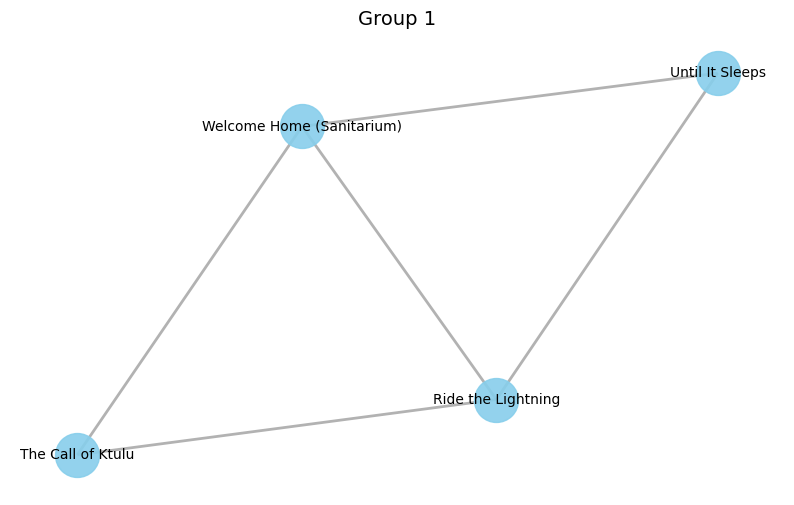

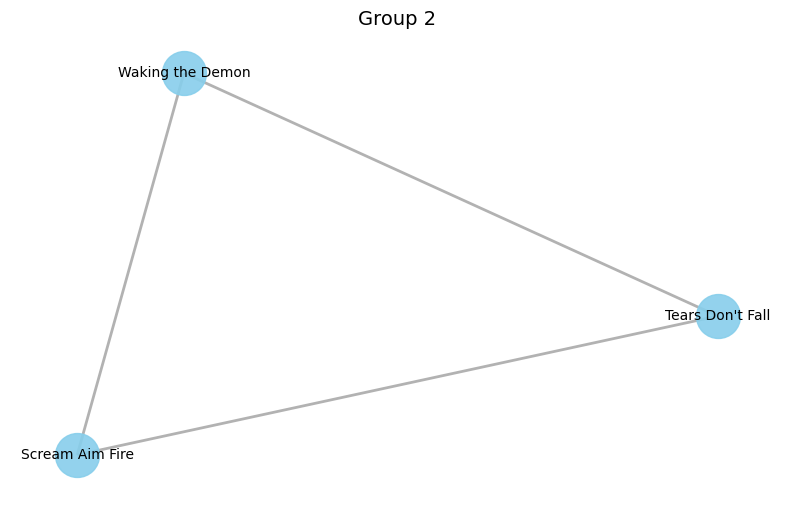

In [58]:
# Create the full graph
G = nx.Graph()

# Add edges for each triplet
for triplet in triplets_with_names:
    for pair in combinations(triplet, 2):
        G.add_edge(pair[0], pair[1])

# Identify connected components (clusters)
groups = [G.subgraph(c).copy() for c in nx.connected_components(G)]

# Plot each cluster
for i, group in enumerate(groups):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(group, seed=42)  # Use spring layout for neat arrangement
    nx.draw_networkx_nodes(group, pos, node_size=1000, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(group, pos, width=2, edge_color='gray', alpha=0.6)
    nx.draw_networkx_labels(group, pos, font_size=10, font_color='black')
    plt.title(f"Group {i + 1}", fontsize=14)
    plt.axis('off')  # Turn off axes
    plt.show()

/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.031501940877873995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[song1, song2] = support
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.031501940877873995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[song2, song1] = support  # Symmetric pairs
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.025380710659898477' has dtype incompatible

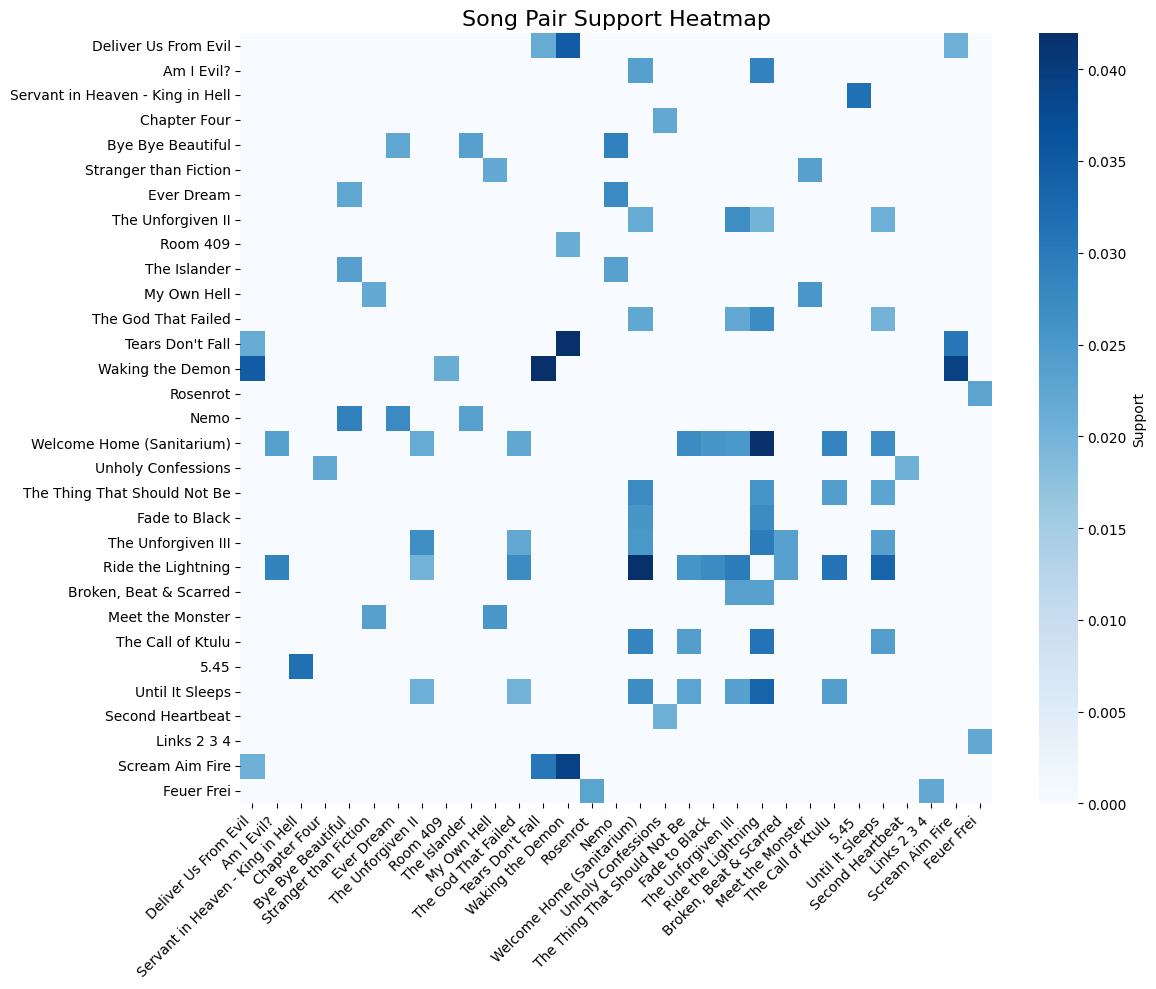

In [59]:
# Prepare data for heatmap
songs = list(set([item for pair in filtered_dublets.keys() for item in pair]))
heatmap_data = pd.DataFrame(0, index=songs, columns=songs)

for (song1, song2), support in filtered_dublets.items():
    heatmap_data.loc[song1, song2] = support
    heatmap_data.loc[song2, song1] = support  # Symmetric pairs

# Plot heatmap without annotations
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(
    heatmap_data,
    annot=False,  # Remove annotations
    cmap="Blues",  # Use a blue colormap
    cbar_kws={'label': 'Support'}  # Add color bar label
)
plt.title('Song Pair Support Heatmap', fontsize=16)  # Increase title font size
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)  # Adjust y-axis label font size
plt.tight_layout()  # Adjust layout for better readability
plt.show()